## Importing packages

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices
import statsmodels.api as sm
from sqlalchemy import create_engine

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

import getpass
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

········


## Loading data

In [2]:
query = '''SELECT * from credit_card_classification.credit_card_data;'''

data = pd.read_sql_query(query, engine)

## Data exploration

In [3]:
data.head(7)

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
5,6,No,Air Miles,Letter,Medium,1,No,High,3,1,4,No,1114.75,1847,1365,750
6,7,No,Air Miles,Letter,Medium,1,No,Medium,2,1,3,No,283.75,468,188,347


In [4]:
data.shape

(17976, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       17976 non-null  int64  
 1   offer_accepted        17976 non-null  object 
 2   reward                17976 non-null  object 
 3   mailer_type           17976 non-null  object 
 4   income_level          17976 non-null  object 
 5   bank_accounts_open    17976 non-null  int64  
 6   overdraft_protection  17976 non-null  object 
 7   credit_rating         17976 non-null  object 
 8   credit_cards_held     17976 non-null  int64  
 9   homes_owned           17976 non-null  int64  
 10  household_size        17976 non-null  int64  
 11  own_your_home         17976 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  int64  
 14  q2_balance            17976 non-null  int64  
 15  q3_balance         

We observe there are a total of 17976 entries and there are not null values.

## Exploring categoricals

In [6]:
data_cat = data.select_dtypes('object')
data_cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


In [22]:
def categoricals_distribution(data):
    for x in data_cat:
        plt.subplots(figsize=(8, 4))
        sns.countplot(data_cat[x], palette="Set3")
        sns.set(font_scale=1.15)
        print(' \n{} {}\n\n{}\n{}\n'.format('Column:',x,'Distribution:',(data_cat[x].value_counts(normalize=True).round(2).to_string())))
        plt.ylabel('')
        plt.xlabel('')
        plt.show()

 
Column: offer_accepted

Distribution:
No     0.94
Yes    0.06



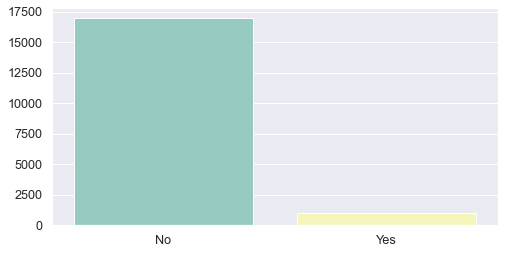

 
Column: reward

Distribution:
Air Miles    0.34
Cash Back    0.33
Points       0.33



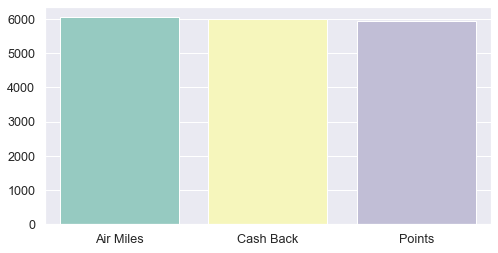

 
Column: mailer_type

Distribution:
Postcard    0.51
Letter      0.49



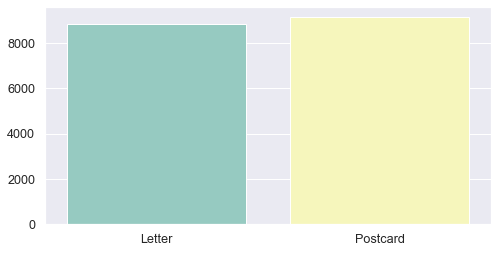

 
Column: income_level

Distribution:
Medium    0.50
High      0.25
Low       0.25



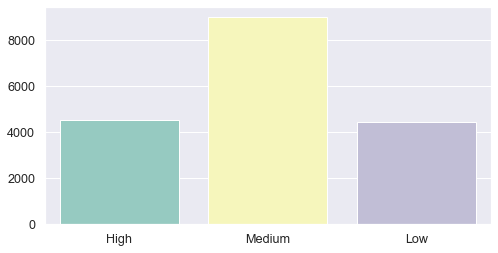

 
Column: overdraft_protection

Distribution:
No     0.85
Yes    0.15



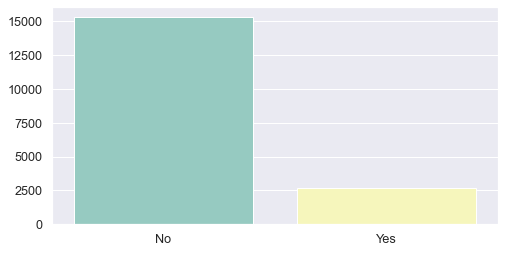

 
Column: credit_rating

Distribution:
High      0.34
Medium    0.33
Low       0.33



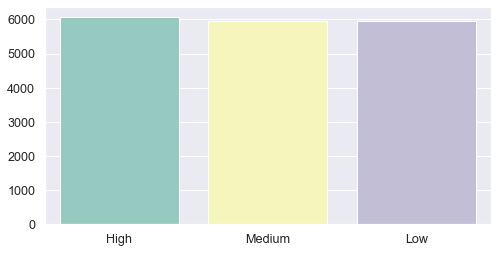

 
Column: own_your_home

Distribution:
Yes    0.65
No     0.35



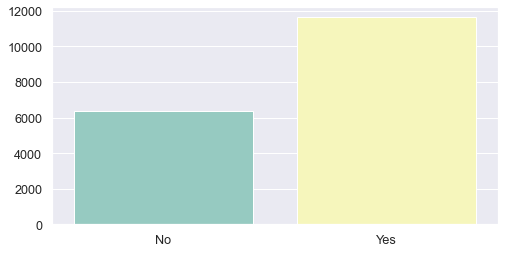

In [23]:
 categoricals_distribution(data)

## Exploring numericals

In [9]:
data.describe().round(0).astype(int)

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance
count,17976,17976,17976,17976,17976,17976,17976,17976,17976
mean,9000,1,2,1,3,941,910,999,1042
std,5197,0,1,0,1,350,620,457,553
min,1,1,1,1,1,48,0,0,0
25%,4499,1,1,1,3,788,393,663,633
50%,9000,1,2,1,3,1007,772,1032,946
75%,13501,1,2,1,4,1153,1521,1342,1463
max,18000,3,4,3,9,3366,3450,3421,3823


In [10]:
data_num = data.select_dtypes('number')
data_num.head()

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance
0,1,1,2,1,4,1160.75,1669,877,1095
1,2,1,2,2,5,147.25,39,106,78
2,3,2,2,1,2,276.50,367,352,145
3,4,2,1,1,4,1219.00,1578,1760,1119
4,5,1,2,1,6,1211.00,2140,1357,982


## Data cleaning

In [11]:
data = data.set_index('customer_number')

## Check for multicollinearity

### Numericals: correlation matrix

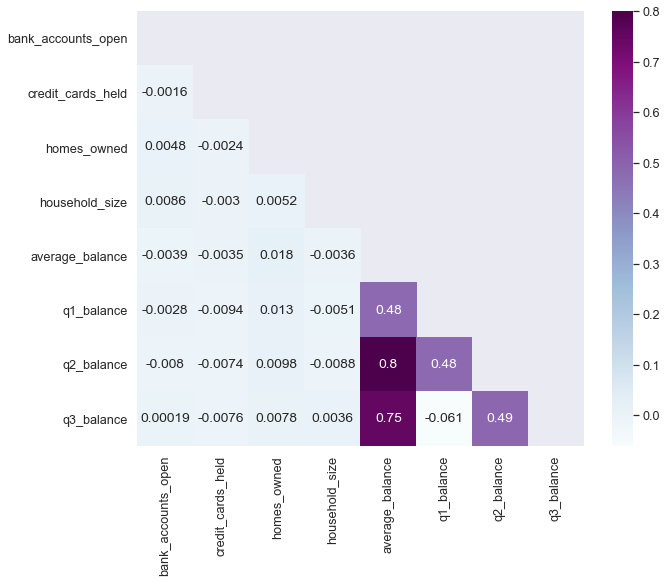

In [12]:
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(data.corr(), mask=mask, annot=True, cmap="BuPu")
sns.set_style("white")
plt.show()

### Categoricals & Numericals: VIF

### Categoricals: Chi Square

## Train-test split

In [13]:
X = data.drop('offer_accepted', axis=1)
y = data['offer_accepted']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature engineering

### Categoricals encoding

In [15]:
X_cat_enc = pd.get_dummies(data_cat, drop_first=True)
y_enc = pd.get_dummies(y, drop_first=True)

In [16]:
X_model = np.concatenate([data_num, X_cat_enc], axis=1)
y_model = y_enc

### Numericals (outliers, boxcox)

## Data standardization

In [17]:
# MINMAX, STANDARDSCALER, NORMALIZER

## SELECT MODEL

In [18]:
#LINEAR, POLINOMIAL, KNN, RANDOM FOREST

## EVALUATE MODEL

In [19]:
#CLASSIFICATION: CONFUSION, MATRIX, KAPPA, F1 SCORE, MCC